In [71]:
# imports

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


import unicodedata
import re

from bs4 import BeautifulSoup
import requests
import os
import json

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import prepare as prep

from sklearn.model_selection import train_test_split
import sklearn.model_selection

from scipy import stats
from scipy.stats import norm, binom



from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

## import data

In [2]:
# original df

f = pd.read_csv('all_books.csv', index_col=0)

In [3]:
f.shape

(3998, 11)

In [4]:
# nytbs df

b = pd.read_csv('books_feat_on_NYBS').drop(columns = 'Unnamed: 0')

In [5]:
b.shape

(1045, 4)

In [6]:
# looking at best sellers

b.isna().sum()

Date        0
Book        0
Author      0
Month     968
dtype: int64

In [7]:
# read in the dataframe of the books

df = prep.prep_data('all_books.csv')

In [8]:
# dropping 'Picture Books'

df = df[df['genre'] != 'Picture Books']

In [9]:
# setting year to int

df.year_published = df.year_published.astype('int64')

In [10]:
# finding rows with non-years

[re.findall(r"[^0-9]", str(x)) for x in df.year_published]

# setting to a series and DF of non-years
empty = pd.DataFrame(pd.Series([re.findall(r"[^0-9]", str(x)) for x in df.year_published]))



## cleaning, exploring`

In [11]:
# how many nan

df.isna().sum()

title                    0
summary                  0
year_published           0
author                   0
review_count             0
number_of_ratings        0
length                   0
genre                    0
rating                   0
reviews               1969
cleaned_title            0
cleaned_summary          0
successful               0
lemmatized_summary       0
neg                      0
neutral                  0
pos                      0
compound                 0
sentiment                0
dtype: int64

**No NaNs appear in important columns.**

In [60]:
df.shape

(3665, 19)

## train—test split

In [15]:
def split(df):
    train, test = train_test_split(df, test_size = .2, random_state = 42, stratify = df.successful)
    return train, test

**1 / True = successful (bestseller), 0 / False = not a bestseller**

In [16]:
train, test = split(df)
train.shape, test.shape

((2932, 19), (733, 19))

#### We'll be doing k-folds, so no need to have a validate portion here

### Does the length of a book have a relationship to its success ?

In [17]:
train.sample()

,title,summary,year_published,author,review_count,number_of_ratings,length,genre,rating,reviews,cleaned_title,cleaned_summary,successful,lemmatized_summary,neg,neutral,pos,compound,sentiment
1474,The Finkler Question,"Julian Treslove, a professionally unspectacula...",2010,Howard Jacobson,2180,15090,307.0,Fiction,2.81,NaN,the finkler question,"julian treslove, a professionally unspectacula...",False,julian treslove professionally unspectacular d...,0.149,0.721,0.13,-0.5839,very negative


In [21]:
# successful books

besties = train[train['successful'] == True]

**127 bestseller books in train. Assigning to a variable in order to explore page length.**

In [22]:
# mean length of pages

besties['length'].mean()

476.8503937007874

In [23]:
# median length of pages

besties['length'].median()

405.0

**The mean length of best sellers is 477 pages, the median is 400 pages.**

In [24]:
# standard deviation

besties['length'].std()

205.47981319535052

**Standard deviation of about 205 pages. So, 68% of NYT bestsellers have a length of 272 to 682 pages.**

In [25]:
long_books = besties[besties['length'] > 682]
long_books.shape

(18, 19)

**18 books have more than 682 pages.** Now to compare with generalised / random books list.

### Non-bestsellers



In [29]:
# isolating unsuccessful books 

sadness = train[train['successful'] == False]

In [30]:
sadness['length'].max(), sadness['length'].min()

(4211.0, 12.0)

In [31]:
sadness['length'].mean()

355.20213903743314

In [32]:
# standard deviation of non-bestsellers

sadness['length'].std()

175.46700311539715

**Standard deviation of about 175 pages. So, 68% of non-bestsellers have a length between 180 and 530 pages.**

### Exploring length and year published

H_O : There is no relationship between the length of a book and the year that it was published.

H_a : There is a relationship between the length of a book and the year that it was published.

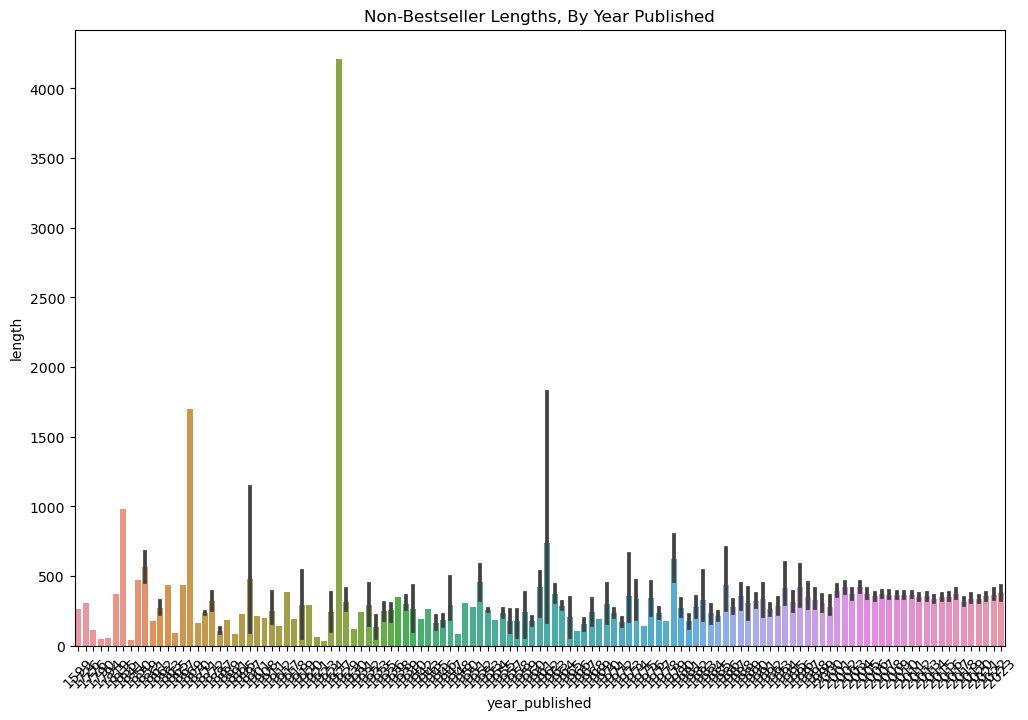

In [33]:
plt.figure(figsize=(12, 8))

plt.title('Non-Bestseller Lengths, By Year Published')
sns.barplot(y = sadness['length'], x = sadness['year_published'])

plt.xticks(rotation = 45)

plt.show()


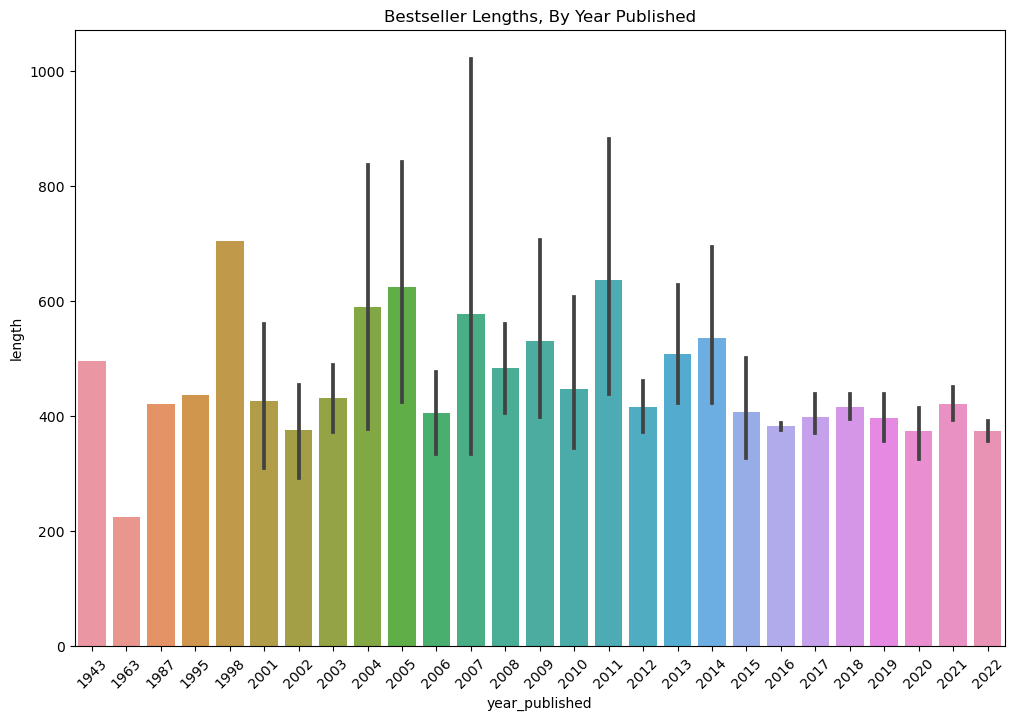

In [34]:
plt.figure(figsize=(12, 8))


plt.title('Bestseller Lengths, By Year Published')

sns.barplot(y = besties['length'], x = besties['year_published'])

plt.xticks(rotation = 45)

plt.show()

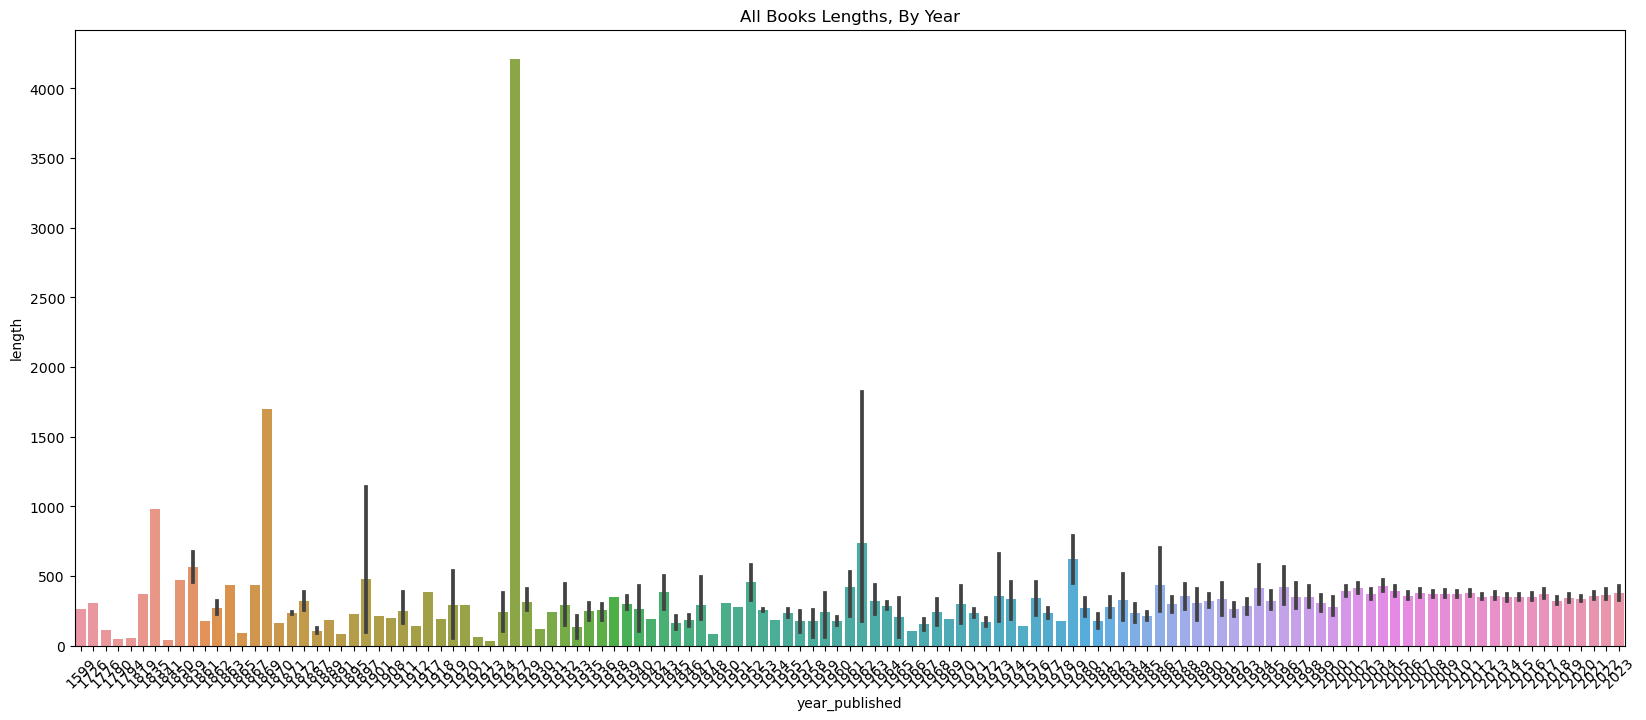

In [35]:
plt.figure(figsize=(20, 8))


plt.title('All Books Lengths, By Year')

sns.barplot(y = train['length'], x = train['year_published'])

plt.xticks(rotation = 45)

plt.show()

**The distribution for all there dataframes is relatively uniform; a chi-square test is appropriate here.**

In [36]:
# chi-square function

def chi_sq(a, b):
    '''
    This function will take in two arguments in the form of two discrete variables 
    and runs a chi^2 test to determine if the the two variables are independent of 
    each other and prints the results based on the findings.
    '''
    alpha = 0.05
    
    result = pd.crosstab(a, b)

    chi2, p, degf, expected = stats.chi2_contingency(result)

    print(f'Chi-square  : {chi2:.4f}') 
    print("")
    print(f'P-value : {p:.4f}')
    print("")
    if p / 2 > alpha:
        print("We fail to reject the null hypothesis.")
    else:
        print(f'We reject the null hypothesis ; there is a relationship between the target variable and the feature examined.')
        

In [37]:
# chi-square on train for length and year published

a = train['length']
b = train['year_published']

In [38]:
chi_sq(a, b)

Chi-square  : 95431.3919

P-value : 0.0000

We reject the null hypothesis ; there is a relationship between the target variable and the feature examined.


In [39]:
# chi-square on besties  for length and year published

v = besties['length']
w = besties['year_published']

In [40]:
chi_sq(v, w)

Chi-square  : 2357.3233

P-value : 0.6894

We fail to reject the null hypothesis.


In [41]:
# chi-square on sadness for length and year published

t = sadness['length']
u = sadness['year_published']

In [42]:
chi_sq(t, u)

Chi-square  : 92195.1044

P-value : 0.0000

We reject the null hypothesis ; there is a relationship between the target variable and the feature examined.


**TAKEAWAYS: There is a relationship between the length of the book (positive correlation) and the year that it was published, particularly for books not on the NYT Best Seller list, and for the train dataset. The length of the book and the year that it was published did not have a relationship for NYT Best Sellers.**

## Exploring length and successs

H_O : There is no relationship between the length of a book and its landing on the NYT Best Seller list.

H_a : There is a relationship between the length of a book and its landing on the NYT Best Seller list.

In [43]:
# plotting all books

def book_len_success():
    
    '''
    this function uses the training dataset to plot 
    the target ('successful') against the length in 
    pages of each book. it puts out a barplot.
    '''
    plt.figure(figsize=(8, 5))

    plt.title('Success Of Book Based On Average Page Length')

    graphed = sns.barplot(x = train['successful'], y = train['length'], palette = 'CMRmap')

    # set xtick labels and properties
    plt.xticks([0, 1], 
               [ 'Not On List', 'Bestseller'],
               rotation = 25)

    # plt.legend([],[]) --this line unnecessary here
    plt.yticks(np.arange(0, 600, 100))

    # display y axis grids
    # graphed.yaxis.grid(True)

    plt.ylabel('Count')
    plt.xlabel('Appearance On NYT Best Seller List')

    plt.show()

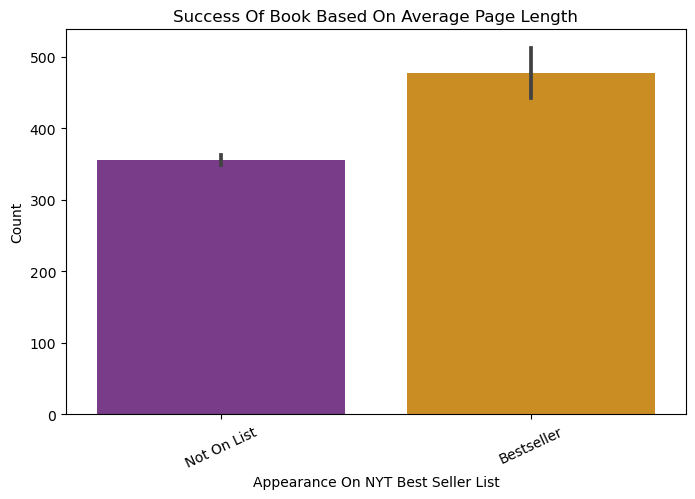

In [47]:
book_len_success()

**It appears that bestsellers have, on average, a longer average page count than books that are not NYT Best Sellers.**

In [48]:
# chi-square on train for length and success

r = train['length']
s = train['successful']

In [49]:
chi_sq(r, s)

Chi-square  : 788.2500

P-value : 0.0000

We reject the null hypothesis ; there is a relationship between the target variable and the feature examined.


**TAKEAWAYS: It appears, both from the bar plot and from the chi-square test, that there is a significant relationship between book length and its appearing on the NYT Best Seller list. Bestsellers, on average, have a longer page length than non-bestsellers. This discovery is also supported by the cumulative density function results.**

### Using .cdf on bestsellers and non-bestsellers

In [50]:
# bestsellers

# mean
m = 477

# standard deviation
s = 205

# Define the normal distribution
bestseller_len = stats.norm(m, s)

## Find the value where 95% of the values / variables are less than unknown-value-X : Use PPF.
best_cdf = bestseller_len.cdf(191)
best_cdf

0.0814895338637503

**8pc chance of a successful book having a length of 191 pages or less.**

In [51]:
# mean of unsuccessful books
m = 355

# standard deviation
s = 175

nonbest_length = stats.norm(m, s)

nonbest_cdf = nonbest_length.cdf(191)
nonbest_cdf

0.17434253936040328

**17.4pc chance of an unsuccessful book having 200 or less pages.**

### What about sentiment score distribution ?¶


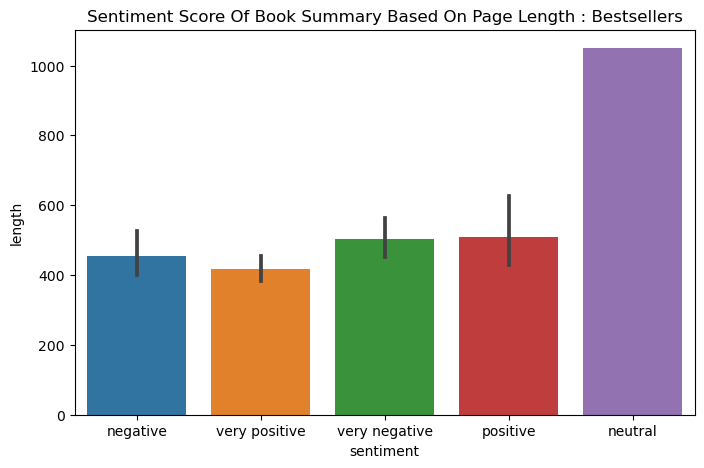

In [52]:
# plotting bestseller books : length vs sentiment score


plt.figure(figsize=(8, 5))

plt.title('Sentiment Score Of Book Summary Based On Page Length : Bestsellers')

sns.barplot(x = besties['sentiment'], y = besties['length'])


plt.show()

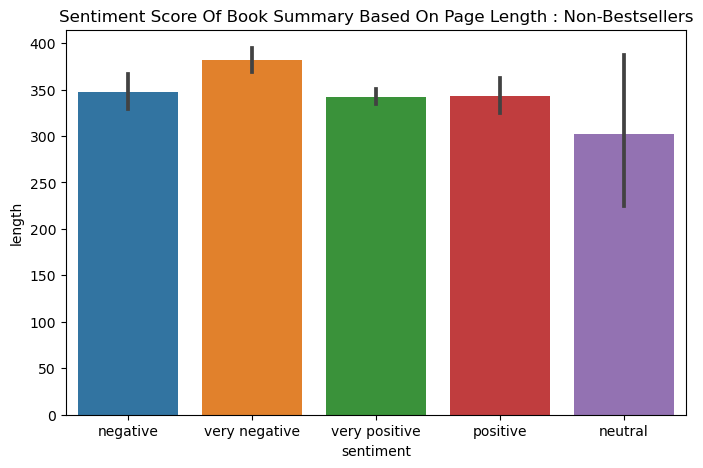

In [53]:
# plotting unsuccessful books : length vs sentiment score


plt.figure(figsize=(8, 5))

plt.title('Sentiment Score Of Book Summary Based On Page Length : Non-Bestsellers')

sns.barplot(x = sadness['sentiment'], y = sadness['length'])

plt.show()


**TAKEAWAYS: Length of book does not seem to have much relationship to the book-summary sentiment score. There was one bestseller with a neutral score, which led to it not being able to have an average page length calculation.**

In [54]:
a = besties[besties['sentiment'] == 'very negative']
a['title'].value_counts().sum()

65

In [55]:
b = besties[besties['sentiment'] == 'negative']
b['title'].value_counts().sum()

7

In [56]:
e = besties[besties['sentiment'] == 'neutral']
e['title'].value_counts().sum()

1

In [57]:
d = besties[besties['sentiment'] == 'positive']
d['title'].value_counts().sum()

11

In [58]:
c = besties[besties['sentiment'] == 'very positive']
c['title'].value_counts().sum()

43

**Of the bestseller sentiment scores, 65 have very negative scores, 7 have negative, 1 has neutral, 11 have positive and 43 have very positive.**

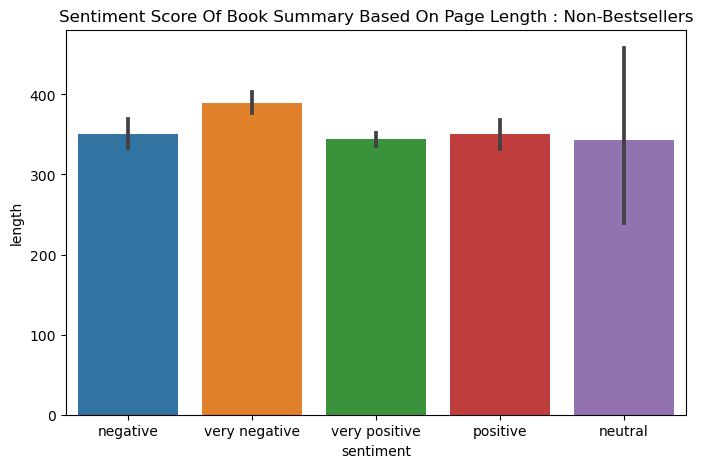

In [59]:
# plotting all TRAIN books : length vs sentiment score


plt.figure(figsize=(8, 5))

plt.title('Sentiment Score Of Book Summary Based On Page Length : Non-Bestsellers')

sns.barplot(x = train['sentiment'], y = train['length'])

plt.show()


# Modelling

In [64]:
# decision tree with depth of 7    
    
def decision_7(X_train, y_train, target):
    
    '''
    this function intakes the X_train & y_train and 
    runs a decision tree on them with a max depth of 7.
    It outputs the accuracy.
    '''

    # initialise the Decision Tree Classifier = clf
    seed = 42
    clf7 = DecisionTreeClassifier(max_depth = 7, random_state = seed)

    ### fitting the model : 
    clf7 = clf7.fit(X_train, y_train)

    # accurcy of the decision tree model
    print()
    print(f'Decision Tree Accuracy, max depth of 7 : {round(clf7.score(X_train, y_train), 4)}')    
    
    return clf7
    

In [67]:
# splitting into X & y

X_train =  train.drop(columns = "successful")
y_train = train['successful']

In [291]:
# decision_7(X_train, y_train, 'successful')

# TF-IDF for word columns

In [288]:
def get_tf(column):

    # obtain TF-IDF score
    tfidf = TfidfVectorizer()

        # fit-transform
    bag_o_words = tfidf.fit_transform(train[column])

        # create df of transformed & fit data : TF-IDF score
    word_df = pd.DataFrame(bag_o_words.todense(),
                        columns = tfidf.get_feature_names_out())


    print()
    print('- - - - - - - - - - - - - - -')
    print('Dataframe of Term Frequency scores :')
    return word_df
    print()
    print('- - - - - - - - - - - - - - -')

In [378]:
lem_sum_tf = get_tf('lemmatized_summary')
lem_sum_tf


- - - - - - - - - - - - - - -
Dataframe of Term Frequency scores :


,aa,aahz,aambc,aanen,aarav,aaron,aaronovitch,aaronsohn,ab,aba,...,zuckerberg,zuckoff,zuckoffs,zum,zumindest,zuni,zusak,zuversicht,zwanzig,zwischen
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [295]:
lem_sum_tf.min(), lem_sum_tf.max()

(aa            0.0
 aahz          0.0
 aambc         0.0
 aanen         0.0
 aarav         0.0
              ... 
 zuni          0.0
 zusak         0.0
 zuversicht    0.0
 zwanzig       0.0
 zwischen      0.0
 Length: 30430, dtype: float64,
 aa            0.099101
 aahz          0.225965
 aambc         0.102095
 aanen         0.096881
 aarav         0.146213
                 ...   
 zuni          0.104558
 zusak         0.147526
 zuversicht    0.059956
 zwanzig       0.077280
 zwischen      0.099635
 Length: 30430, dtype: float64)

In [318]:
# function to get the idf of a column

def get_idf(column):

    # obtain TF-IDF score
    tfidf = TfidfVectorizer()

#         # fit-transform
    bag_o_words = tfidf.fit_transform(train[column])

    words_series = pd.Series(dict(zip(
                            tfidf.get_feature_names_out(), 
                            tfidf.idf_)))
    print()
    print('- - - - - - - - - - - - - - -')
    print('Key / value pairs of words and frequencies :')
    print(word_series)
    return words_series

In [221]:
# idf of lemmatised sum

word_series = get_idf('lemmatized_summary')


- - - - - - - - - - - - - - -
Key / value pairs of words and frequencies :
aa            8.290634
aahz          8.290634
aambc         8.290634
aanen         8.290634
aarav         8.290634
                ...   
zuni          8.290634
zusak         7.885169
zuversicht    8.290634
zwanzig       8.290634
zwischen      7.597487
Length: 30430, dtype: float64


In [287]:
word_series.shape

(30430,)

In [200]:
len(word_series)

30430

In [304]:
# turning into a DF & resetting the index

lem_sum_idf = pd.DataFrame(word_series)

lem_sum_idf = lem_sum_idf.reset_index()

In [305]:
lem_sum_idf.columns

Index(['index', 0], dtype='object')

In [306]:
# renaming columns

lem_sum_idf = lem_sum_idf.rename(columns = {'index' : 'word', 0 : 'IDF'})

lem_sum_idf

,word,IDF
0,aa,8.290634
1,aahz,8.290634
2,aambc,8.290634
3,aanen,8.290634
4,aarav,8.290634
...,...,...
30425,zuni,8.290634
30426,zusak,7.885169
30427,zuversicht,8.290634
30428,zwanzig,8.290634


In [307]:
# finding min & max IDF

lem_sum_idf['IDF'].min(), lem_sum_idf['IDF'].max()

(1.8136615255278228, 8.290633888417506)

In [308]:
# lem_sum_idf[lem_sum_idf['IDF'] < 3]

In [309]:
# lem_sum_idf[lem_sum_idf['IDF'] > 8]

In [310]:
# getting rid of words with an IDF of greater than 8

lem_sum_idf = lem_sum_idf[lem_sum_idf['IDF'] < 7.5]

In [313]:
# getting rid of words with an IDF of less than 3

lem_sum_idf = lem_sum_idf[lem_sum_idf['IDF'] > 3.5]

In [376]:
lem_sum_idf

,word,IDF
5,aaron,7.192022
12,abandon,4.707115
15,abandonment,7.037871
18,abbey,6.904340
23,abby,7.374343
...,...,...
30377,zero,6.498874
30403,zoey,6.585886
30405,zombie,6.681196
30406,zone,6.150568


In [349]:
# isolate word col

lem_sum_words = lem_sum_idf["word"]

In [361]:
# turn to list

lem_sum_words_list = lem_sum_words.to_list()
lem_sum_words_list

['aaron',
 'abandon',
 'abandonment',
 'abbey',
 'abby',
 'abduct',
 'abduction',
 'abide',
 'abigail',
 'ability',
 'able',
 'aboard',
 'abolition',
 'abraham',
 'abroad',
 'abruptly',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorb',
 'absurd',
 'absurdity',
 'abundant',
 'abuse',
 'abusive',
 'academic',
 'academy',
 'accept',
 'acceptance',
 'accepts',
 'access',
 'accessible',
 'accident',
 'accidental',
 'accidentally',
 'acclaim',
 'acclaimed',
 'accompany',
 'accomplish',
 'accomplishment',
 'accord',
 'account',
 'accuracy',
 'accurate',
 'accusation',
 'accuse',
 'ace',
 'acerbic',
 'ache',
 'achieve',
 'achievement',
 'achingly',
 'acid',
 'acknowledge',
 'acquaintance',
 'acquire',
 'acre',
 'across',
 'act',
 'action',
 'actionable',
 'actionpacked',
 'active',
 'actively',
 'activism',
 'activist',
 'activity',
 'actor',
 'actress',
 'actual',
 'actually',
 'acute',
 'ad',
 'ada',
 'adam',
 'adams',
 'adapt',
 'adaptation',
 'adapts',
 'add',
 'addict',
 'addi

# now, compare lem_sum_words_list to the TF df and then drop from the TF dataframe not on lem_sum_words_list

In [380]:
# subset a list into an existing df and keep only words from the list

lem_sum_keepers = lem_sum_tf[lem_sum_words_list]

In [381]:
# it worked

lem_sum_keepers 

,aaron,abandon,abandonment,abbey,abby,abduct,abduction,abide,abigail,ability,...,youthful,youve,zach,zealand,zen,zero,zoey,zombie,zone,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.096742,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### IDF for titles

In [225]:
title_idf = get_idf('cleaned_title')


- - - - - - - - - - - - - - -
Key / value pairs of words and frequencies :
aa            8.290634
aahz          8.290634
aambc         8.290634
aanen         8.290634
aarav         8.290634
                ...   
zuni          8.290634
zusak         7.885169
zuversicht    8.290634
zwanzig       8.290634
zwischen      7.597487
Length: 30430, dtype: float64


In [276]:
# turn results into a DF 

def idf_to_df(column):
    
    '''
    this function operates off of the get_idf(column)
    function and uses the same column name. It returns
    the original IDF list, the min and the max IDF for 
    the column, along with the idf as a useable dataframe
    '''

    idf = get_idf(column)

    # turning into a DF & resetting the index

    idf= pd.DataFrame(idf)

    idf = idf.reset_index()

    # renaming columns

    idf_df = idf.rename(columns = {'index' : 'word', 0 : 'IDF'})
    
    print()
    print(f'Min IDF : ', idf_df['IDF'].min(), f', max IDF : ',idf_df['IDF'].max())
    return idf_df

In [277]:
clean_title_idf = idf_to_df('cleaned_title')


- - - - - - - - - - - - - - -
Key / value pairs of words and frequencies :
aa            8.290634
aahz          8.290634
aambc         8.290634
aanen         8.290634
aarav         8.290634
                ...   
zuni          8.290634
zusak         7.885169
zuversicht    8.290634
zwanzig       8.290634
zwischen      7.597487
Length: 30430, dtype: float64

Min IDF :  1.830729434039971 , max IDF :  8.290633888417506


In [275]:
clean_title_idf.shape

(1314, 2)

In [265]:
clean_title_idf[clean_title_idf['IDF'] < 4.8]

,word,IDF
175,and,3.400285
512,by,3.946828
1354,for,4.749675
1766,in,2.105455
2091,life,4.388661
2540,of,2.707138
3533,the,1.830729
3593,to,4.163500
3929,world,4.564940


In [274]:
# getting rid of words with an IDF of greater than 8

clean_title_idf = clean_title_idf[clean_title_idf['IDF'] < 8]

In [272]:
# getting rid of words with an IDF of greater than 8

clean_title_idf = clean_title_idf[clean_title_idf['IDF'] > 4.8]

In [284]:
clean_title_idf.shape

(3970, 2)

### IDF of author

In [278]:
# using the function

author_idf = idf_to_df('author')


- - - - - - - - - - - - - - -
Key / value pairs of words and frequencies :
aa            8.290634
aahz          8.290634
aambc         8.290634
aanen         8.290634
aarav         8.290634
                ...   
zuni          8.290634
zusak         7.885169
zuversicht    8.290634
zwanzig       8.290634
zwischen      7.597487
Length: 30430, dtype: float64

Min IDF :  4.940729801142901 , max IDF :  8.290633888417506


In [279]:
# shape

author_idf.shape

(2639, 2)

**Not going to drop author names.**
